In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ttest_ind


In [2]:
# Load data
X = np.loadtxt('Zeisel_expr.txt').T
genes = np.loadtxt('Zeisel_genes.txt', delimiter='\n', dtype=str)
labels = np.loadtxt('Zeisel_labels.txt', delimiter='\n', dtype=str)

In [3]:
print(X.shape)
print(genes.shape)
print(labels.shape)

(3005, 19972)
(19972,)
(3005,)


In [4]:
# Useful Python-style tricks for working with the data:

# Trick 1
# You often want to slice the count matrix X to obtain only cells for a particular cell type (label).
# One common use case is that you want to plot cells of each type with a distinct color.
# Python supports condition-style boolean slicing which makes these kinds of queries easy.
# For example, the below code selects only the Astrocytes cells (subset of rows).

X_Astrocytes = X[labels == 'Astrocytes', :]

# Trick 2
# Sometimes you need to filter multiple arrays based on some condition.
# Then you typically need to store the boolean condition as a separate variable.
# For example, the below code filters both 'X' and 'genes' to get only genes whose name starts with a T.

T_filter = np.array([gene[0] == 'T' for gene in genes.tolist()])

genes_T = genes[T_filter]
X_T = X[:, T_filter]

# Trick 3
# Sometimes you need to sort an array based on the values of some other array.
# numpy has a good argsort function to accomplish this
# For example, the below code sorts 'genes' based on total read count across all cells

gene_sort_index = np.argsort(np.sum(X, axis=0))
genes_sorted = genes[gene_sort_index]


2.1 (a)
The number of cells is: 3005, and the number of genes is: 19972
2.1 (b)
The maximum count over all cells  and genes is: 10738.0, and the average count is: 0.698810264486754
2.1 (c)


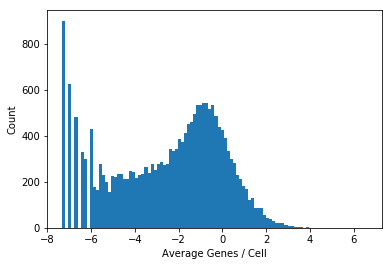

In [5]:
# Problem 2.1 Single-cell stats

# a) Calculate number of cells and number of genes
print("2.1 (a)")
print("The number of cells is: "  + str(X.shape[0]) + ", and the number of genes is: " + str(X.shape[1]));

# b) Calculate average and maximum count over all cells and genes
print("2.1 (b)")
print("The maximum count over all cells  and genes is: " + str(X.max()) + ", and the average count is: " + str(X.mean()));

# c) Plot log(average count) for each gene over cells (the average is taken over cells) as a histogram
print("2.1 (c)")
log_counts = np.log(np.mean(X, axis = 0))
plt.hist(log_counts, bins = 100)

plt.xlabel("Average Genes / Cell")
plt.ylabel("Count")

plt.show()

In [6]:
# Problem 2.2 PCA/tSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

totalCounts = sum(X)
random_state = 100

# Filter the count matrix to remove low-count genes
X_modified = X[:, totalCounts >= 25]

# Add pseudocount and log transform count matrix (log(1 + X))
X_modified = np.log(1 + X_modified)

# Apply PCA on X and keep the 50 first PCs 
X_modified_pca = PCA(n_components=50, random_state = random_state)
X_modified_principalComponents = X_modified_pca.fit_transform(X_modified)

# Apply 2-dimensional tSNE on the 50 PCs. Plot the 2-dimensional tSNE embedding and color each cell according to cell type
X_embedded = TSNE(n_components=2, random_state = random_state).fit_transform(X_modified_principalComponents)


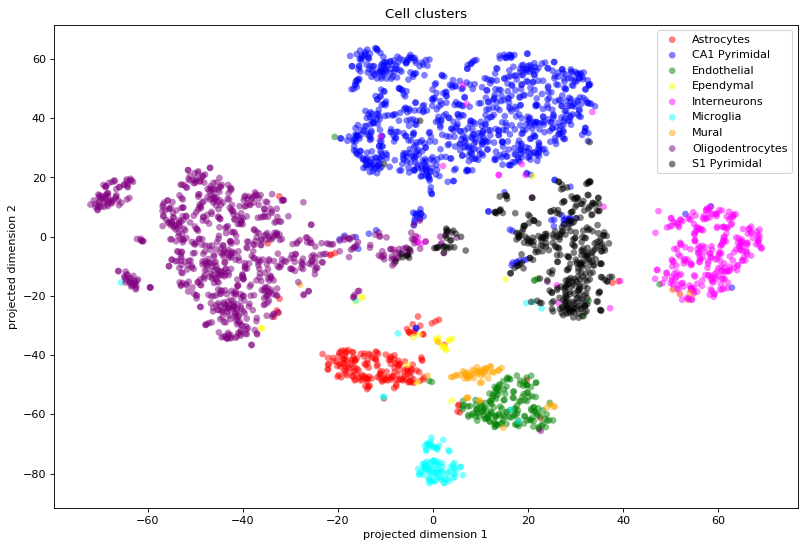

In [7]:
unique_labels = np.unique(labels)
data = []
colors = ("red", "blue", "green", "yellow", "magenta", "cyan", "orange", "purple", "black" )

for label in unique_labels:
    data.append(X_embedded[labels == label, :])

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

for data, color, label in zip(data, colors, unique_labels):
    x, y = data[:, 0], data[:, 1]
    plt.scatter(x, y, alpha=0.5, c=color, edgecolors='none', label=label)

plt.xlabel("projected dimension 1")
plt.ylabel("projected dimension 2")
plt.title("Cell clusters")
plt.legend()
plt.show()

In [8]:
# Problem 2.3 K-means
def kmeans_cluster(X, n_iter, clusters_number, verbose=False, randomly=True):
    
    converging_iteration = -1
    
    # Initialize k cluster centers by picking random data points and store them in matrix 'centers'
    # Currently, the cluster centers are just all-zero vectors
    centers = np.zeros((clusters_number, X.shape[1]))
    
    if randomly:
        centers = X[np.random.choice(X.shape[0], clusters_number, replace = False)]
    else:
        centers = X[range(clusters_number), :]
    
    # For each iteration, keep track of the cluster assignment of each data point in vector 'cluster assignment'.
    cluster_assignment = np.zeros(X.shape[0], dtype=np.int)
    
    # For each iteration, store the mean within-cluster Sum-of-squares error in list 'mses'.
    mses = np.zeros(n_iter, dtype=np.double)
    
    for curr_iter in range(0, n_iter) :
        
        if verbose :
            if curr_iter % 10 == 5 :
                print('K-means iteration ' + str(curr_iter))
        
        # The E-step (Assign data points to clusters)
        for i in range(X.shape[0]):
            chosen_index = -1
            minimum_distance = math.inf
            for j in range(clusters_number):
                diff = centers[j, :] - X[i, :]
                current_distance = np.dot(diff, diff)
                if(current_distance < minimum_distance):
                    chosen_index = j
                    minimum_distance = current_distance
            cluster_assignment[i] = chosen_index
            

        # The M-step (Re-estimate the cluster centers)  
        for i in range(clusters_number):
            cluster_points = X[cluster_assignment == i]
            centers[i] = np.mean(cluster_points, axis = 0)
        
        # Calculate and store the mean within-cluster Sum-of-squares error for this iteration
        for i in range(clusters_number):
            mse = 0
            cluster_points = X[cluster_assignment == i]
            for j in range(cluster_points.shape[0]):
                diff = centers[i, :] - cluster_points[j, :]
                mse += np.dot(diff, diff)
            mses[curr_iter] += mse
        mses[curr_iter] = mses[curr_iter] / X.shape[0]
        
        if (curr_iter > 0 and mses[curr_iter] == mses[curr_iter - 1]):
            converging_iteration = curr_iter - 1
            mses = mses[0:converging_iteration]
            break
        
    return centers, cluster_assignment, mses, converging_iteration

K-means iteration 5
K-means iteration 15
K-means iteration 25
K-means iteration 35
Converged at iteration: 35


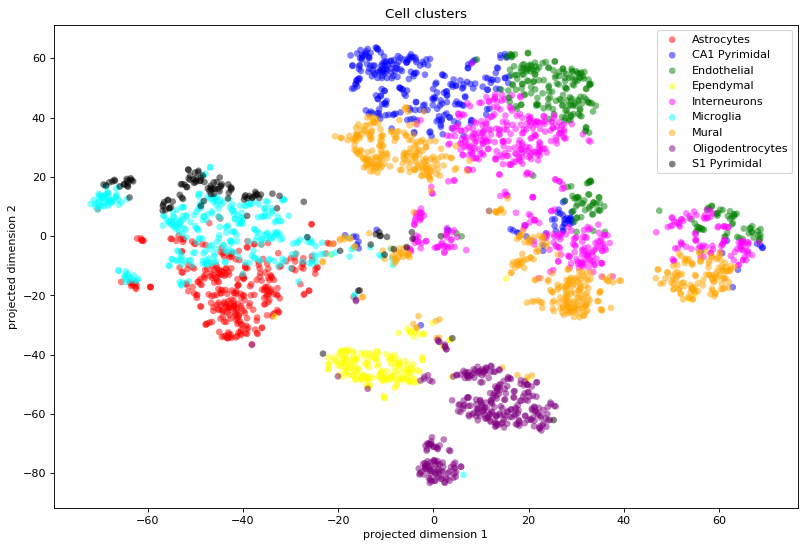

In [9]:
# Run K-means on the 50-PC dimensional count data, and plot (color) clusters over the tSNE embedding
means, assignments, mses, converging_iteration = kmeans_cluster(X_modified_principalComponents, 100, 9, verbose=True, randomly=True)

print("Converged at iteration: " + str(converging_iteration))
data = []
unique_assignments = np.unique(assignments)

for assignment in unique_assignments:
    data.append(X_embedded[assignments == assignment, :])

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

for data, color, label in zip(data, colors, unique_labels):
    x, y = data[:, 0], data[:, 1]
    plt.scatter(x, y, alpha=0.5, c=color, edgecolors='none', label=label)

plt.xlabel("projected dimension 1")
plt.ylabel("projected dimension 2")
plt.title("Cell clusters")
plt.legend()
plt.show()

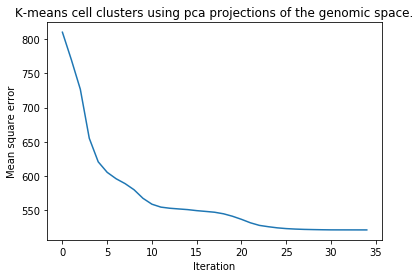

The final mse is: 521.2219628956881


In [10]:
# Plot the K-means within-cluster sum-of-squares error vs. iteration number
plt.plot(mses)
plt.xlabel("Iteration")
plt.ylabel("Mean square error")
plt.title("K-means cell clusters using pca projections of the genomic space.")
plt.show()
print("The final mse is: " + str(mses[-1]))

How fast does the clustering converge?
This totally depends on the points where the clusters were initialized. We will probably get a different number for every time we run the random code because K-means will stuck in a different local minimum.

Does the K-means clustering seem reasonable (i.e. do groups of cells in tSNE correspond to distinct clusters)?
I don't think it is. I believe the tsne one is way better and I believe this is because the way the two different algorithms work. In tsne, we are trying to bring the datapoints that belong together by taking into account all the distances (inter and intra clusters) and weighting them using the t-distribution. While in kmeans, we only consider the datapoints in one cluster. Probably with a guided kmeans where the user determines the initial centers, we could be able to do get better results.
